<a href="https://colab.research.google.com/github/minat-hub/Machine-learning-projects/blob/main/predict_health_costs_with_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Note: You are currently reading this using Google Colaboratory which is a cloud-hosted version of Jupyter Notebook. This is a document containing both text cells for documentation and runnable code cells. If you are unfamiliar with Jupyter Notebook, watch this 3-minute introduction before starting this challenge: https://www.youtube.com/watch?v=inN8seMm7UI*

---

In this challenge, you will predict healthcare costs using a regression algorithm.

You are given a dataset that contains information about different people including their healthcare costs. Use the data to predict healthcare costs based on new data.

The first two cells of this notebook import libraries and the data.

Make sure to convert categorical data to numbers. Use 80% of the data as the `train_dataset` and 20% of the data as the `test_dataset`.

`pop` off the "expenses" column from these datasets to create new datasets called `train_labels` and `test_labels`. Use these labels when training your model.

Create a model and train it with the `train_dataset`. Run the final cell in this notebook to check your model. The final cell will use the unseen `test_dataset` to check how well the model generalizes.

To pass the challenge, `model.evaluate` must return a Mean Absolute Error of under 3500. This means it predicts health care costs correctly within $3500.

The final cell will also predict expenses using the `test_dataset` and graph the results.

In [1]:
# Import libraries. You may or may not use all of these.
!pip install -q git+https://github.com/tensorflow/docs
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score

from xgboost import XGBRegressor

#xgboost triggers a deprecation warning which we ignore here 
import warnings
warnings.filterwarnings(action='ignore')

%matplotlib inline

try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns

import tensorflow_docs as tfdocs
import tensorflow_docs.plots
import tensorflow_docs.modeling

     |████████████████████████████████| 1.0MB 4.3MB/s 


In [2]:
# Import data
!wget https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
dataset = pd.read_csv('insurance.csv')
dataset.tail()

--2021-01-06 10:01:20--  https://cdn.freecodecamp.org/project-data/health-costs/insurance.csv
Resolving cdn.freecodecamp.org (cdn.freecodecamp.org)... 104.26.2.33, 104.26.3.33, 172.67.70.149, ...
Connecting to cdn.freecodecamp.org (cdn.freecodecamp.org)|104.26.2.33|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/csv]
Saving to: ‘insurance.csv’

insurance.csv           [ <=>                ]  49.09K  --.-KB/s    in 0s      

2021-01-06 10:01:20 (113 MB/s) - ‘insurance.csv’ saved [50264]



,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [3]:
dataset = dataset.copy()
dataset.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,male,31.0,3,no,northwest,10600.55
1334,18,female,31.9,0,no,northeast,2205.98
1335,18,female,36.9,0,no,southeast,1629.83
1336,21,female,25.8,0,no,southwest,2007.95
1337,61,female,29.1,0,yes,northwest,29141.36


In [4]:
dataset.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
expenses    0
dtype: int64

In [5]:
dataset = dataset.dropna()

In [6]:
labels = dataset['sex'].astype('category').cat.categories.tolist()
sex = {'sex' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

print(sex)

{'sex': {'female': 1, 'male': 2}}


In [7]:
labels = dataset['smoker'].astype('category').cat.categories.tolist()
smoker = {'smoker' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

print(smoker)

{'smoker': {'no': 1, 'yes': 2}}


In [8]:
labels = dataset['region'].astype('category').cat.categories.tolist()
region = {'region' : {k: v for k,v in zip(labels,list(range(1,len(labels)+1)))}}

print(region)

{'region': {'northeast': 1, 'northwest': 2, 'southeast': 3, 'southwest': 4}}


In [9]:
dataset.replace(sex, inplace=True)

In [10]:
dataset.replace(smoker, inplace=True)

In [11]:
dataset.replace(region, inplace=True)

In [12]:
dataset.tail()

,age,sex,bmi,children,smoker,region,expenses
1333,50,2,31.0,3,1,2,10600.55
1334,18,1,31.9,0,1,1,2205.98
1335,18,1,36.9,0,1,3,1629.83
1336,21,1,25.8,0,1,4,2007.95
1337,61,1,29.1,0,2,2,29141.36


In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   int64  
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   int64  
 5   region    1338 non-null   int64  
 6   expenses  1338 non-null   float64
dtypes: float64(2), int64(5)
memory usage: 83.6 KB


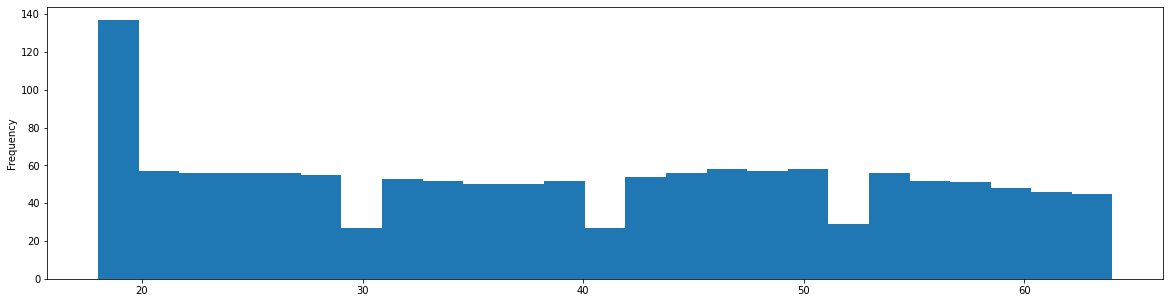

In [14]:
dataset.age.plot(kind='hist', bins=25, figsize=(20,5));

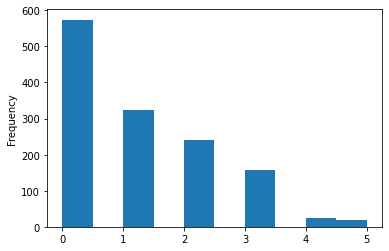

In [15]:
dataset.children.plot(kind='hist');

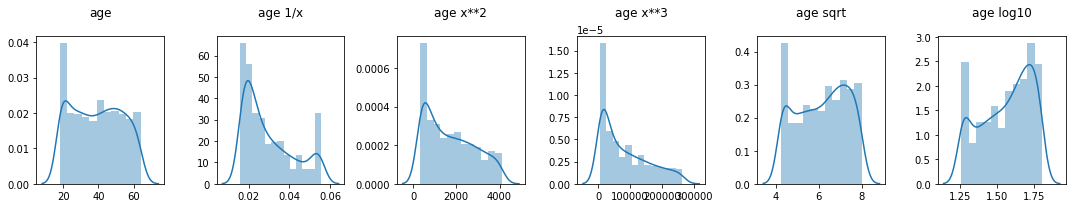

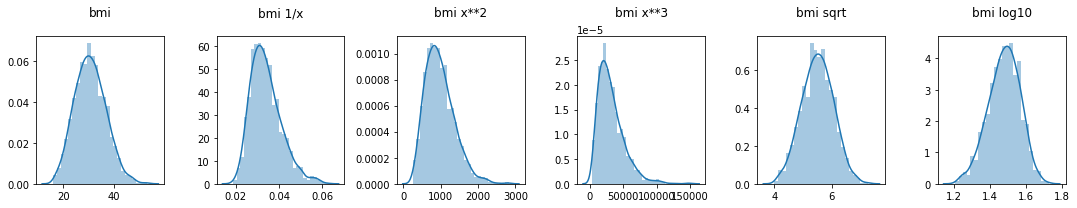

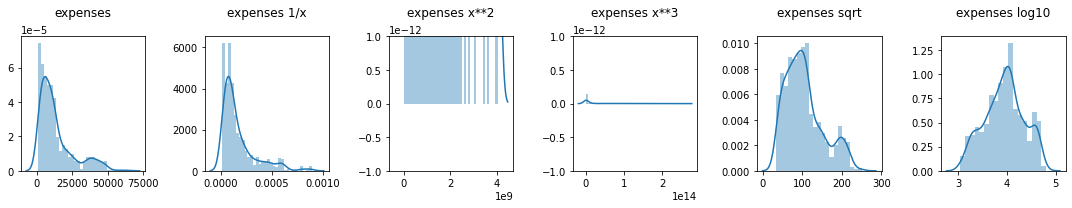

In [16]:
# for the other features visual exploration starts with feature transformation using different lambda functions 
# this was chosen since their datatypes indicated that they only contain numbers
# the approach was additionally chosen as an alternative to automated polynomial feature transformation due to its broader spectrum
# its easier for the model to predict something that looks similar to a normal (Gauss) distribution

df_t = pd.DataFrame()
transformations = {'1/x': lambda x: 1/x, 
                  'x**2': lambda x: x**2,
                  'x**3': lambda x: x**3,
                  'sqrt': lambda x: np.sqrt(x),
                  'log10': lambda x: np.log10(x)
                  }

for item in ['age', 'bmi', 'expenses']:
    fig, axs = plt.subplots(nrows=1, ncols=6, figsize=(15, 3))
    axs[0].set_title(item, pad=20)
    norm = sns.distplot(dataset[item], ax=axs[0])
    norm.set(xlabel='', ylabel='')
    
    for i, (keys, values) in enumerate(transformations.items()):
        df_t['{}_{}'.format(item, keys)] = dataset[item].apply(values)
        axs[i+1].set_title(item + ' ' + keys, pad=20)
        p = sns.distplot(df_t['{}_{}'.format(item, keys)], ax=axs[i+1])
        p.set(xlabel='', ylabel='')
    #fig.savefig('./' + item + '.png')
    plt.tight_layout()

In [17]:
df_dummies = pd.get_dummies(dataset, columns=['sex', 'smoker', 'region', 'children'], drop_first=True)

In [18]:
df_dummies.head()

,age,bmi,expenses,sex_2,smoker_2,region_2,region_3,region_4,children_1,children_2,children_3,children_4,children_5
0,19,27.9,16884.92,0,1,0,0,1,0,0,0,0,0
1,18,33.8,1725.55,1,0,0,1,0,1,0,0,0,0
2,28,33.0,4449.46,1,0,0,1,0,0,0,1,0,0
3,33,22.7,21984.47,1,0,1,0,0,0,0,0,0,0
4,32,28.9,3866.86,1,0,1,0,0,0,0,0,0,0


In [19]:
y, X = np.log10(df_dummies.loc[:,'expenses']), df_dummies.drop(['expenses'], axis=1)

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, random_state=42)

In [21]:
def print_scores(regressor, X_train, y_train, X_test, y_test):
    """
    This function uses supplied regressor algorithms to train a model and predict
    the target value.
    Ultimately the accuracy and other scoring parameters (R^2, MSE, RMSE, LRMSE, MAE) are shown
    """
    regressor.fit(X_train, y_train)
    y_prediction = regressor.predict(X_test)
    accuracy = accuracy_score(y_true = y_test.astype(int), y_pred = y_prediction.astype(int))
    print('Variance-score (R^2): {0:.4f}'.format(regressor.score(X_test, y_test)))
    print('Mean squared error: {0:.4f}'.format(np.mean((regressor.predict(X_test) - y_test) ** 2)))
    print('Root mean squared error: {0:.4f}'.format(np.sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))))
    print('log root mean squared error: {0:.4f}'.format(np.sqrt(np.square(np.log10(y_prediction + 1) - np.log10(y_test + 1)).mean())))
    print('mean absolute error: {0:.4f}'.format(mean_absolute_error(y_test, y_prediction)))
    print('Accuracy: {0:.2f}%'.format(accuracy*100))
    return

In [22]:
# first a simple linear regression model from sklearn is used to establish a baseline for the other models
print_scores(LinearRegression(), X_train, y_train, X_test, y_test)

Variance-score (R^2): 0.8060
Mean squared error: 0.0329
Root mean squared error: 0.1814
log root mean squared error: 0.0160
mean absolute error: 0.1192
Accuracy: 92.16%


In [23]:
# trying a Lasso regression next, which (untuned) performs worse than the baseline
print_scores(Lasso(), X_train, y_train, X_test, y_test)

Variance-score (R^2): 0.2709
Mean squared error: 0.1237
Root mean squared error: 0.3516
log root mean squared error: 0.0311
mean absolute error: 0.2821
Accuracy: 73.51%


In [24]:
# Ridge regression with some experience based tuning performs slightly better than linear regression
print_scores(Ridge(alpha=0.1, normalize=True), X_train, y_train, X_test, y_test)

Variance-score (R^2): 0.7941
Mean squared error: 0.0349
Root mean squared error: 0.1869
log root mean squared error: 0.0167
mean absolute error: 0.1289
Accuracy: 92.54%


In [25]:
regressor = XGBRegressor()
print_scores(regressor, X_train, y_train, X_test, y_test)

[10:01:26] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Variance-score (R^2): 0.8546
Mean squared error: 0.0247
Root mean squared error: 0.1570
log root mean squared error: 0.0140
mean absolute error: 0.0856
Accuracy: 92.16%


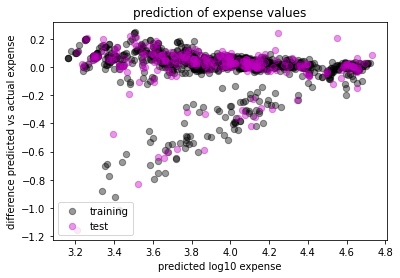

In [26]:
# in order to understand the good and 'bad' predictions we can visualize the predicted vs actual values in a plot
plt.scatter(regressor.predict(X_train), regressor.predict(X_train) - y_train, c='black', s=40, label='training', alpha=0.4)
plt.scatter(regressor.predict(X_test), regressor.predict(X_test) - y_test, c='m', s=40, label='test', alpha=0.4)
plt.legend(loc='lower left')
plt.title('prediction of expense values')
plt.xlabel('predicted log10 expense')
plt.ylabel('difference predicted vs actual expense');
#plt.savefig('expense_prediction.png')

In [27]:
def evaluate_model_on_mae(model, X_test, y_test):
  """
  helper function to return the models mean absolute error for the predictions
  
  Parameters
  ----------
  model: regression model 
  X_test: test data in tabular format
  y_test: expected target values

  Returns
  ---------
  mean absolute error using sklearn.metrics mean_absolute_error method
  """
  y_prediction = model.predict(X_test)
  return mean_absolute_error(y_test, y_prediction)

In [33]:
def evaluate_model_on_loss(model, X_test, y_test):
  y_prediction = model.predict(X_test)
  return log_loss(y_test, y_prediction)

In [34]:
def evaluate_model_on_mse(model, X_test, y_test):
  y_prediction = model.predict(X_test)
  return mean_squared_error(y_test, y_prediction)

Testing set Mean Abs Error:  0.09 expenses
You passed the challenge. Great job!


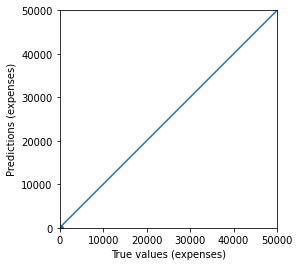

In [41]:
# RUN THIS CELL TO TEST YOUR MODEL. DO NOT MODIFY CONTENTS.
# Test model by checking how well the model generalizes using the test set.

mae = evaluate_model_on_mae(regressor, X_test, y_test)
mse = evaluate_model_on_mse(regressor, X_test, y_test)


print("Testing set Mean Abs Error: {:5.2f} expenses".format(mae))

if mae < 3500:
  print("You passed the challenge. Great job!")
else:
  print("The Mean Abs Error must be less than 3500. Keep trying.")

# Plot predictions.
test_predictions = regressor.score( X_test, y_test).flatten()

a = plt.axes(aspect='equal')
plt.scatter(mae, test_predictions)
plt.xlabel('True values (expenses)')
plt.ylabel('Predictions (expenses)')
lims = [0, 50000]
plt.xlim(lims)
plt.ylim(lims)
_ = plt.plot(lims,lims)
